In [85]:
!pip install 'kaggle-environments>=0.1.6'

In [86]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [87]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [88]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [89]:
import numpy as np
import gym
from kaggle_environments import make, evaluate
import random
from matplotlib import pyplot as plt
from random import choice
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor

### Define Q-Network

In [90]:
import torch
from torch import nn
from torch.nn import functional as f 


class NavNetwork(nn.Module):
    
    def __init__(self, state_size, action_size, layer1_size, layer2_size, layer3_size):
        """ Initializes parameters and constructs the network graph.
        
        Parameters
            action_size(int): size of the action space
            state_size(int): size of the state space
            layer1_size(int): size of the first hidden layer
            layer2_size(int): size of the second hidden layer
        """
        super(NavNetwork, self).__init__()
        
        self.action_size = action_size
        self.state_size = state_size
        self.layer1_size = layer1_size
        self.layer2_size = layer2_size
        # Construct the network
        self.fc1 = nn.Linear(self.state_size, layer1_size)
        self.fc2 = nn.Linear(layer1_size, layer2_size)
        self.fc3 = nn.Linear(layer2_size, layer3_size)
        self.output = nn.Linear(layer3_size, self.action_size)
        
    def forward(self, x):
        """ Computes the output of the network given an input. """
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return(self.output(x))

### Define Q-Agent.

In [154]:
import numpy as np
import random
import torch
from torch import nn
from torch.nn import functional as F
from collections import deque, namedtuple
import torch.optim as optim


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
BUFFER_SIZE = 100000


class Agent():
    
    def __init__(self, state_size, action_size, gamma, update_every, lr, tau=0.2):
        """ Inititalize the off-policy agent with all the parameters. 
        
        Parameters:
            train_network(NavNetwork): the network whose weights will be updated based on the target network. 
            target_network(NavNetwork): the network used for the train network to base it's loss function. 
            buffer_size(int): size of the experience replay buffer.
            epsilon(float): E-greedy policy.
            gamma(float): Gamma in Q(s,a) = r + Gamma * max(q(s1,a1))
            num_iterations(int): the number of training iteratins after which the train_network is updated.
            lr(float)L learning rate of the optimizer
        """
        # Initialize environment specific variables
        self.state_size = state_size
        self.action_size = action_size
        self.lr = lr
        # Initialize Networks .
        self.target_network = NavNetwork(state_size, action_size, 64, 64, 32).to(device)
        self.train_network = NavNetwork(state_size, action_size, 64, 64, 32).to(device)
        self.optimizer = optim.Adam(self.train_network.parameters(), lr=self.lr)
        # Initialize hyperparameters
        self.gamma = gamma
        self.update_every = update_every
        self.t_step = 0
        self.tau = tau
        # Experience Replay Buffer
        self.buffer = ExperienceReplay(self.action_size, BUFFER_SIZE, BATCH_SIZE)
    
    def inference(self, state, epsilon): 
        """ Function to run the agent using the current policy.
        
            Parameters:
                state: state of the environment
                is_greedy: whether to take greedy action"""
        state = torch.from_numpy(state).float().unsqueeze(0).to(device) # unsqueeze because first dimension has to be batch
        # Convert the network to eval mode.
        self.train_network.eval()
        # https://discuss.pytorch.org/t/model-eval-vs-with-torch-no-grad/19615
        with torch.no_grad():
            action_values = self.train_network(state)
        # set the network to train again
        self.train_network.train()
        # check for e-greedy approach
        if random.random() > epsilon:
            return(np.argmax(action_values.cpu().data.numpy()))
        else:
            return(random.choice(np.arange(self.action_size)))
    
    def step(self, state, action, reward, next_state, done):
        """ Compute the following algorithmic steps:
            1) Store transition (φt, at, rt, φt+1) in D
            2) Sample random minibatch of transitions (φj , aj , rj , φj+1) from D.
                
        Parameters:
            state: current state of the environment
            action: the action taken at the current state
            next_state: the next state of the environment after action was taken
            reward: the reward for the state transition
        """
        # Store in memory buffer
        self.buffer.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % self.update_every
        if(self.t_step == 0):
            if(len(self.buffer) > BATCH_SIZE):
            # sample transitions
                experiences = self.buffer.sample()
                self.learn(experiences)

    def learn(self, experiences):
        """ Computes the following algorithmic steps : 
            1) Set yj = rj for terminal φj+1
                        rj + γ maxa0 Q(φj+1, a0; θ) for non-terminal φj+1
            2) Perform a gradient descent step on (yj − Q(φj , aj ; θ))2
        
        Parameters:
            experiences(tuple): tuple of state, action, next_state, reward sampled from the replay buffer.
       """
        states, actions, rewards, next_states, dones = experiences
        # Compute maximum Q-values for the next state
        with torch.no_grad():
            max_actions = self.train_network(next_states).max(dim=1)[1].unsqueeze(1)
            q_targets_next = self.target_network(next_states).gather(1, max_actions)
            q_targets = rewards + (self.gamma * q_targets_next * (1 - dones))
        # Compute q-values for the present state and action pair
        q_training = self.train_network(states).gather(1, actions)
        # Compute loss
        loss = F.mse_loss(q_training, q_targets)
        # Zero the gradients
        self.optimizer.zero_grad()
        # backprop
        loss.backward()
        # Optimize
        self.optimizer.step()
        # update weights of the target 
        for target_params, train_params in zip(self.target_network.parameters(), self.train_network.parameters()):
            target_params.data.copy_(self.tau * train_params.data + (1 - self.tau) * target_params.data)

                   
class ExperienceReplay:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
                   
        

### Define the env using openai gym class

In [155]:
class ConnectX(gym.Env):
    def __init__(self, switch_prob=0.5):
        self.env = make('connectx', debug=False)
        self.pair = [None, 'random']
        self.trainer = self.env.train(self.pair)
        self.switch_prob = switch_prob

        # Define required gym fields (examples):
        config = self.env.configuration
        self.action_space = gym.spaces.Discrete(config.columns)
        self.observation_space = gym.spaces.Discrete(config.columns * config.rows)

    def switch_trainer(self):
        self.pair = self.pair[::-1]
        self.trainer = self.env.train(self.pair)

    def step(self, action):
        return self.trainer.step(action)
    
    def reset(self):
        if np.random.random() < self.switch_prob:
            self.switch_trainer()
        return self.trainer.reset()
    
    def render(self, mode='human', **kwargs):
        return self.env.render(mode='ipython')

In [156]:
env = ConnectX()

In [157]:
print(f"Size of Action Space: {env.action_space} ")
print(f"Reward Min Max: {env.reward_range}")
print(f"State Space Range:{env.observation_space}")

Size of Action Space: Discrete(7) 
Reward Min Max: (-inf, inf)
State Space Range:Discrete(42)


In [186]:
state = env.reset()            # get the current state
score = 0     
while True:
  action = np.random.randint(env.action_space.n)        # select an action
  state, reward, done, info = env.step(action)         # see if episode has finished
  score += reward                                # update the score                           # roll over the state to next time step
  if done:                                       # exit loop if episode finished
    break
env.render()                                     # initialize the score
   
print("Score: {}".format(score))

Score: 1


In [159]:
dqn_agent = Agent(state_size=env.observation_space.n, action_size=env.action_space.n, 
                  gamma=0.99, update_every=5, lr=1e-4)

Episode 100	Average Score: -3.29
Episode 200	Average Score: -1.57
Episode 300	Average Score: -1.35
Episode 400	Average Score: 0.62
Episode 500	Average Score: -0.27
Episode 600	Average Score: 4.56
Episode 700	Average Score: 1.57
Episode 800	Average Score: 1.97
Episode 900	Average Score: 2.40
Episode 1000	Average Score: 1.12
Episode 1100	Average Score: 2.40
Episode 1200	Average Score: 5.00
Episode 1300	Average Score: 3.80
Episode 1400	Average Score: 6.26
Episode 1500	Average Score: 10.28
Episode 1600	Average Score: 5.53
Episode 1700	Average Score: 8.88
Episode 1800	Average Score: 9.30
Episode 1900	Average Score: 7.10
Episode 2000	Average Score: 7.35
Episode 2100	Average Score: 9.54
Episode 2200	Average Score: 6.69
Episode 2300	Average Score: 7.35
Episode 2400	Average Score: 11.62
Episode 2500	Average Score: 7.99
Episode 2600	Average Score: 6.94
Episode 2700	Average Score: 11.58
Episode 2800	Average Score: 14.56
Episode 2900	Average Score: 13.64
Episode 3000	Average Score: 9.19
Episode 31

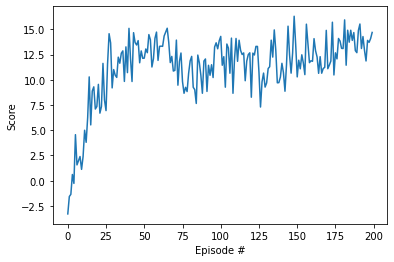

In [218]:
def dqn(n_episodes=20000, max_t=100, eps_start=1.0, eps_end=0.01, eps_decay=0.9995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()# reset the environment
        state = np.array(state['board']).astype(np.float)
        score = 0
        for t in range(max_t):
            action = dqn_agent.inference(state, eps)
            next_state, reward, done, info = env.step(action.item())
            next_state = np.array(next_state['board']).astype(np.float)
            if reward == 1:
              reward = 20
            elif reward == -1:
              reward=-20
            else:
              reward = -0.1
            dqn_agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            scores.append(np.mean(scores_window))   
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Create an agent

In [231]:
def agent1(obs, config):
  action = dqn_agent.inference(np.array(obs["board"]), 0.001)
  return(action.item())

In [233]:
env = make("connectx")

# Two random agents play one game round
env.run([agent1, "negamax"])
env.render(mode="ipython")

In [235]:
def get_win_percentages(agent1, agent2, n_rounds=100):
    # Use default Connect Four setup
    config = {'rows': 6, 'columns': 7, 'inarow': 4}
    # Agent 1 goes first (roughly) half the time          
    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    # Agent 2 goes first (roughly) half the time      
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
    print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
    print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
    print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))

In [236]:
get_win_percentages(agent1=agent1, agent2="random")

Agent 1 Win Percentage: 0.9
Agent 2 Win Percentage: 0.03
Number of Invalid Plays by Agent 1: 7
Number of Invalid Plays by Agent 2: 0


In [237]:
get_win_percentages(agent1=agent1, agent2="negamax")

Agent 1 Win Percentage: 0.0
Agent 2 Win Percentage: 0.83
Number of Invalid Plays by Agent 1: 17
Number of Invalid Plays by Agent 2: 0
